# **TCGA-UCEC Analysis**

Ce notebook effectue l'analyse principale des données TCGA-UCEC après contrôle qualité.

Il réalise les analyses exploratoires, statistiques et visualisations nécessaires pour caractériser le cancer de l'endomètre.

Le dataset traité sera utilisé pour l'analyse différentielle et les enrichissements fonctionnels.

---

**Sections du pipeline:**
- Setup and Configuration
- Data Loading
- Exploratory Analysis
- Statistical Analysis
- Differential Expression Preparation
- Visualization
- Save Processed Data

**Note:** Ce notebook est un template à adapter selon vos besoins spécifiques d'analyse TCGA-UCEC.


# **Setup block**


### Setup and Configuration

In [ ]:
# ==========================================================================================================
# GESTION SYSTÈME & ENVIRONNEMENT
import os                                       # Navigation fichiers
import gc                                       # Gestion mémoire
import warnings                                 # Masquer warnings
from IPython.display import Markdown, display   # Affichage Jupyter

# ----------------------------------------------------------------------------------------------------------
# CALCUL NUMÉRIQUE & VISUALISATION
import numpy as np                              # Calculs numériques
import math                                     # Calculs mathématiques
import matplotlib.pyplot as plt                 # Figures principales
from matplotlib.colors import to_rgb, rgb_to_hsv, hsv_to_rgb, rgb2hex
from matplotlib.gridspec import GridSpec
import seaborn as sns                           # Visualisations statistiques

# ----------------------------------------------------------------------------------------------------------
# ANALYSE DE DONNÉES
import pandas as pd                             # Manipulation de données

# ----------------------------------------------------------------------------------------------------------
# ANALYSE RNA-seq (à adapter selon les besoins)
# import scipy.stats as stats                   # Tests statistiques
# from sklearn.decomposition import PCA          # Analyse en composantes principales
# from sklearn.preprocessing import StandardScaler

# ==========================================================================================================
# --- DÉFINITION DES DOSSIERS ---
PROJECT_ROOT = "C:\\Z\\M2_AIDA\\TCGA_UCEC_project"

DIRS = {
    "DATA":    os.path.join(PROJECT_ROOT, "data"),
    "EXPORTS": os.path.join(PROJECT_ROOT, "data", "exports"),
    "FIGURES": os.path.join(PROJECT_ROOT, "data", "figures"),
    "RESULTS": os.path.join(PROJECT_ROOT, "Results_R_Analysis"),
    "TMP":     os.path.join(PROJECT_ROOT, "tmp_cache"),
    "DOCS":    os.path.join(PROJECT_ROOT, "documentation")
}

for path in DIRS.values():
    os.makedirs(path, exist_ok=True)

os.chdir(PROJECT_ROOT)

# ==========================================================================================================
# --- PARAMÈTRES GÉNÉRAUX ---
warnings.filterwarnings("ignore") 

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (10, 6)

# ==========================================================================================================
print(f"✅ Environnement chargé. Working directory: {os.getcwd()}")
print(f"📁 Dossiers créés:")
for name, path in DIRS.items():
    print(f"   {name}: {path}")


✅ Environnement chargé. Working directory: c:\Z\M2_AIDA\transcriptomics_project


# **Data Loading**

### Dataset analytique Post-QC :

<br>  local:       `data/HBCC_SCZ_CTRL_postQC.h5ad`.

In [8]:
dataset_path = os.path.join(DIRS["DATA"], "HBCC_SCZ_CTRL_postQC.h5ad")
# adata = sc.read_h5ad(dataset_path) >>>>> MemoryError !
adata = sc.read_h5ad(dataset_path, backed='r')  # Lecture en mode backed pour économiser la mémoire
# ** Note technique :** backed mode pour éviter MemoryError.

dictionary_path = os.path.join(DIRS["DATA"],"hbcc_cellxgene_metadata_dictionary.json")
with open(dictionary_path, "r") as f:
    meta_hbcc = json.load(f)

print(f"✅ HBCC_SCZ_CTRL_postQC and metadata dictionary successfully loaded (backed mode). Shape (cells, genes): {adata.shape}")

✅ HBCC_SCZ_CTRL_postQC and metadata dictionary successfully loaded (backed mode). Shape (cells, genes): (414669, 34176)


# Single Cell Analysis

#### **Single-Cell Structure and Cell-Type Representation**

<small>
Cette étape vise à caractériser la structure cellulaire du cortex préfrontal humain dans la cohorte post-QC schizophrénie / contrôles. L’objectif est d’explorer la composition en types cellulaires, de vérifier la cohérence des annotations biologiques et d’évaluer la représentation relative des différents types cellulaires entre les groupes diagnostiques.  
<br><br>
Cette analyse est purement descriptive et exploratoire : aucun reclustering ni analyse différentielle n’est réalisé à ce stade. Elle constitue une étape de validation biologique indispensable avant d’engager des analyses transcriptomiques plus approfondies.  
<br><br>
Les annotations de types cellulaires utilisées proviennent des métadonnées associées à l’atlas HBCC et reflètent une classification experte basée sur des signatures transcriptomiques connues du cortex humain.
</small>


In [9]:
celltype_counts = adata.obs["cell_type"].value_counts()

print("Nombre de cellules par type cellulaire (cohorte SCZ / CTRL) :\n")
print(celltype_counts)


Nombre de cellules par type cellulaire (cohorte SCZ / CTRL) :

cell_type
oligodendrocyte                                                   102662
astrocyte                                                          49099
L2/3 intratelencephalic projecting glutamatergic neuron            45914
oligodendrocyte precursor cell                                     35022
L2/3-6 intratelencephalic projecting glutamatergic neuron          33751
VIP GABAergic cortical interneuron                                 22245
sst GABAergic cortical interneuron                                 20794
microglial cell                                                    20282
pvalb GABAergic cortical interneuron                               20254
endothelial cell                                                    9914
GABAergic neuron                                                    9476
lamp5 GABAergic cortical interneuron                                9302
L6 intratelencephalic projecting glutamatergic neur

#### **Interpretation of Global Cell-Type Composition**

<small>
L’analyse de la composition cellulaire globale de la cohorte post-QC schizophrénie / contrôles met en évidence une organisation conforme aux attentes biologiques pour le cortex préfrontal humain. Les populations gliales dominent largement le jeu de données, en particulier les oligodendrocytes et les astrocytes, reflétant leur abondance physiologique et leur rôle central dans le fonctionnement et le maintien du tissu cortical.  
<br><br>
Les neurones glutamatergiques corticaux constituent la principale population neuronale, avec une représentation importante des neurones intratelencephaliques des couches superficielles (L2/3 et L2/3–6), cohérente avec l’architecture laminaire du cortex. Les neurones inhibiteurs GABAergiques sont également bien représentés, incluant plusieurs sous-types majeurs (VIP, SST, PVALB, LAMP5), témoignant de la diversité interne des circuits inhibiteurs corticaux.  
<br><br>
Les populations non neuronales minoritaires, telles que les cellules endothéliales, péricytes, macrophages périvasculaires et cellules immunitaires périphériques, sont présentes en proportions plus faibles, ce qui est attendu dans un contexte de single-nucleus RNA-seq du cortex.  
<br><br>
Dans l’ensemble, cette distribution confirme que la cohorte post-QC conserve une structure cellulaire biologiquement plausible et représentative du cortex préfrontal humain. Elle valide l’utilisation de ce jeu de données pour l’exploration ultérieure des différences entre groupes diagnostiques, ainsi que pour des analyses ciblées par type cellulaire.
</small>


#### **Cell-Type Composition Stratified by Diagnostic Group (SCZ vs CTRL)**

<small>
Après avoir établi la composition cellulaire globale de la cohorte post-QC, cette étape vise à examiner la répartition des types cellulaires en fonction du groupe diagnostique, en comparant les individus atteints de schizophrénie (SCZ) aux contrôles.  
<br><br>
L’objectif est de vérifier si la structure cellulaire globale est conservée entre les groupes diagnostiques et d’identifier d’éventuelles différences de représentation relatives des principaux types cellulaires. Cette analyse est strictement descriptive et ne constitue pas une analyse différentielle d’expression génique.  
<br><br>
L’exploration de la composition cellulaire par diagnostic permet de s’assurer que les comparaisons transcriptomiques ultérieures ne sont pas dominées par des déséquilibres majeurs de proportions cellulaires, et fournit un cadre interprétatif essentiel pour les analyses en aval.
</small>


In [10]:
celltype_by_disease = (
    adata.obs
    .groupby(["cell_type", "disease"])
    .size()
    .unstack(fill_value=0)
)

print("Nombre de cellules par type cellulaire et groupe diagnostique (SCZ vs contrôles) :\n")
print(celltype_by_disease)


Nombre de cellules par type cellulaire et groupe diagnostique (SCZ vs contrôles) :

disease                                             bipolar II disorder  \
cell_type                                                                 
astrocyte                                                          1443   
endothelial cell                                                    187   
GABAergic neuron                                                    108   
oligodendrocyte precursor cell                                      590   
oligodendrocyte                                                    1303   
T cell                                                               11   
natural killer cell                                                  14   
B cell                                                                1   
plasma cell                                                           0   
microglial cell                                                     283   
perivascular mac

#### **Interpretation of Cell-Type Composition Stratified by Diagnostic Group**

<small>
La stratification de la composition cellulaire par groupe diagnostique met en évidence une forte hétérogénéité des catégories associées à la variable <code>disease</code>. Au-delà des groupes attendus (schizophrénie et contrôles), de nombreuses cellules sont annotées avec des diagnostics composites combinant plusieurs troubles psychiatriques, neurologiques ou métaboliques.  
<br><br>
Cette observation indique que la variable <code>disease</code> encode non seulement un diagnostic principal, mais également des comorbidités, sous forme de chaînes de caractères concaténées. En conséquence, les groupes diagnostiques ne correspondent pas encore à des catégories homogènes directement comparables.  
<br><br>
La présence de ces diagnostics composites souligne l’importance d’une étape de simplification et de recodage des groupes diagnostiques avant toute analyse comparative ou différentielle. Cette étape permettra de définir des groupes biologiquement interprétables, en isolant par exemple les individus atteints de schizophrénie sans comorbidités majeures et les contrôles, tout en excluant ou en traitant séparément les cas complexes.  
<br><br>
Ainsi, cette analyse descriptive remplit un rôle clé de validation et met en évidence la nécessité d’un filtrage diagnostique explicite, qui constituera l’étape suivante du pipeline.
</small>


#### **Diagnostic Group Refinement and Cohort Cleaning**

<small>
L’analyse de la composition cellulaire stratifiée par diagnostic a mis en évidence une forte hétérogénéité de la variable <code>disease</code>, qui inclut de nombreux diagnostics composites combinant plusieurs troubles psychiatriques, neurologiques ou somatiques. Cette structure reflète la richesse clinique du jeu de données HBCC, mais ne permet pas une comparaison directe et interprétable entre groupes biologiquement homogènes.  
<br><br>
L’objectif de cette étape est de simplifier et de clarifier la définition des groupes diagnostiques afin de constituer une cohorte adaptée aux analyses comparatives ultérieures. En particulier, l’analyse se concentrera sur la comparaison entre individus atteints de schizophrénie et individus contrôles, en excluant les cas présentant des comorbidités complexes susceptibles de confondre l’interprétation transcriptomique.  
<br><br>
Cette étape consiste donc à recoder les annotations diagnostiques en catégories simplifiées, à filtrer explicitement les groupes d’intérêt et à produire un jeu de données nettoyé sur le plan clinique. Elle constitue une transition essentielle entre l’exploration descriptive de la structure cellulaire et les analyses transcriptomiques ciblées réalisées en aval.
</small>


In [11]:
adata.obs["simple_diagnosis"] = "OTHER"

adata.obs.loc[
    adata.obs["disease"] == "schizophrenia",
    "simple_diagnosis"
] = "SCZ"

adata.obs.loc[
    adata.obs["disease"] == "normal",
    "simple_diagnosis"
] = "CTRL"

mask = adata.obs["simple_diagnosis"].isin(["SCZ", "CTRL"])

adata_clean = adata[mask]

print("Cellules en entrée :", adata.n_obs)
print("Cellules retenues après simplification diagnostique :", adata_clean.n_obs)
print("\nRépartition des groupes diagnostiques :")
print(adata_clean.obs["simple_diagnosis"].value_counts())


Cellules en entrée : 414669
Cellules retenues après simplification diagnostique : 232274

Répartition des groupes diagnostiques :
simple_diagnosis
CTRL    205073
SCZ      27201
Name: count, dtype: int64


#### **Interpretation of Diagnostic Group Refinement**

<small>
La simplification des annotations diagnostiques a permis de définir une cohorte cliniquement homogène adaptée aux analyses comparatives ultérieures. À partir de 414 669 cellules issues de la cohorte post-QC initiale, 232 274 cellules ont été retenues après application d’un filtrage strict basé sur le diagnostic principal.  
<br><br>
Cette cohorte nettoyée comprend deux groupes clairement définis : un groupe contrôle (CTRL) regroupant 205 073 cellules, et un groupe schizophrénie (SCZ) regroupant 27 201 cellules. Les cellules associées à des diagnostics composites ou à des comorbidités complexes ont été exclues afin de limiter les facteurs de confusion biologiques et cliniques.  
<br><br>
La différence d’effectif entre les groupes reflète la structure du jeu de données original et n’est pas inattendue dans un atlas populationnel. Cette cohorte simplifiée constitue une base robuste pour l’exploration des différences transcriptomiques entre schizophrénie et contrôles, notamment dans des analyses stratifiées par type cellulaire ou sous forme de pseudobulk.
</small>


#### **Selection of Major Cortical Cell Types for Downstream Analyses**

<small>
Après la définition d’une cohorte diagnostique homogène schizophrénie / contrôles, l’étape suivante consiste à sélectionner les principaux types cellulaires du cortex préfrontal qui seront considérés pour les analyses transcriptomiques en aval.  
<br><br>
L’objectif de cette sélection est double. D’une part, elle permet de réduire la complexité du jeu de données en se concentrant sur les populations cellulaires les plus abondantes et les plus pertinentes biologiquement dans le contexte de la schizophrénie. D’autre part, elle vise à garantir une puissance analytique suffisante pour chaque type cellulaire retenu, en excluant les populations très rares susceptibles de produire des résultats instables ou difficilement interprétables.  
<br><br>
Cette étape repose sur les annotations de types cellulaires fournies par l’atlas HBCC et s’inscrit dans une logique descriptive et préparatoire. Elle ne constitue pas encore une analyse différentielle, mais prépare la constitution de sous-ensembles cellulaires cohérents qui serviront de base aux analyses transcriptomiques ciblées et aux approches de type pseudobulk.
</small>


In [13]:
adata_clean_mem = adata_clean.to_memory()

major_cell_types = [
    "oligodendrocyte",
    "astrocyte",
    "microglial cell",
    "oligodendrocyte precursor cell",
    "L2/3 intratelencephalic projecting glutamatergic neuron",
    "L2/3-6 intratelencephalic projecting glutamatergic neuron",
    "L6 intratelencephalic projecting glutamatergic neuron",
    "L6b glutamatergic neuron of the primary motor cortex",
    "L5/6 near-projecting glutamatergic neuron",
    "pvalb GABAergic cortical interneuron",
    "sst GABAergic cortical interneuron",
    "VIP GABAergic cortical interneuron",
    "lamp5 GABAergic cortical interneuron"
]

mask_ct = adata_clean_mem.obs["cell_type"].isin(major_cell_types)
adata_ct = adata_clean_mem[mask_ct]

print("Cellules en entrée :", adata_clean_mem.n_obs)
print("Cellules retenues après sélection des types cellulaires :", adata_ct.n_obs)
print("\nRépartition des types cellulaires retenus :")
print(adata_ct.obs["cell_type"].value_counts())


Cellules en entrée : 232274
Cellules retenues après sélection des types cellulaires : 209093

Répartition des types cellulaires retenus :
cell_type
oligodendrocyte                                              58166
astrocyte                                                    26309
L2/3 intratelencephalic projecting glutamatergic neuron      23451
oligodendrocyte precursor cell                               21762
L2/3-6 intratelencephalic projecting glutamatergic neuron    15987
microglial cell                                              13673
sst GABAergic cortical interneuron                           12550
VIP GABAergic cortical interneuron                           12533
pvalb GABAergic cortical interneuron                         11385
lamp5 GABAergic cortical interneuron                          5115
L6 intratelencephalic projecting glutamatergic neuron         3908
L6b glutamatergic neuron of the primary motor cortex          2410
L5/6 near-projecting glutamatergic neuron       

#### **Interpretation of Major Cell-Type Selection**

<small>
La sélection des types cellulaires majeurs a permis de constituer un sous-ensemble biologiquement pertinent du cortex préfrontal, tout en conservant l’essentiel de la diversité cellulaire du jeu de données. À partir de 232 274 cellules appartenant à la cohorte schizophrénie / contrôles, 209 093 cellules ont été retenues après exclusion des populations rares ou peu représentées.  
<br><br>
Les populations conservées correspondent aux principaux types cellulaires attendus dans le cortex humain adulte, incluant les oligodendrocytes et leurs précurseurs, les astrocytes, les microglies, ainsi que plusieurs sous-types neuronaux glutamatergiques et GABAergiques. Les oligodendrocytes et les astrocytes représentent les populations les plus abondantes, reflétant leur rôle central dans l’organisation et le fonctionnement du tissu cortical.  
<br><br>
Les interneurones GABAergiques (pvalb, sst, VIP, lamp5) et les différents sous-types de neurones glutamatergiques intratélencéphaliques sont également bien représentés, garantissant une base suffisante pour des analyses comparatives spécifiques à chaque type cellulaire.  
<br><br>
L’exclusion des types cellulaires rares (notamment certaines populations vasculaires ou immunitaires faiblement représentées) permet de limiter le bruit et d’assurer une puissance statistique adéquate pour les analyses transcriptomiques en aval. Cette sélection constitue ainsi un compromis raisonné entre complexité biologique et robustesse analytique, préparant le jeu de données aux étapes de normalisation, de réduction de dimension et d’analyse différentielle.
</small>


#### **Normalization and Preparation for Downstream Single-Cell Analyses**

<small>
Après la sélection d’une cohorte diagnostique homogène (schizophrénie / contrôles) et des principaux types cellulaires du cortex préfrontal, les données sont désormais prêtes pour les étapes centrales de l’analyse single-cell transcriptomique.  
<br><br>
L’objectif de cette étape est de rendre les profils d’expression comparables entre cellules en corrigeant les différences de profondeur de séquençage, puis de transformer les données afin de stabiliser la variance. Cette normalisation est une condition indispensable à la réduction de dimension, au clustering et aux analyses différentielles en aval.  
<br><br>
Le prétraitement comprend classiquement une normalisation des comptages par cellule, suivie d’une transformation logarithmique. Ces opérations permettent de conserver l’information biologique tout en limitant l’impact des variations techniques inhérentes aux données single-nucleus RNA-seq.  
<br><br>
Cette étape marque la transition entre la phase de préparation des données et le cœur de l’analyse transcriptomique, qui reposera sur l’identification des principales sources de variation et la structuration de l’espace d’expression génique.
</small>


In [14]:
sc.pp.normalize_total(adata_ct, target_sum=1e4)
sc.pp.log1p(adata_ct)

print("Normalisation et transformation logarithmique terminées.")
print("Dimensions de l'objet :", adata_ct.shape)


Normalisation et transformation logarithmique terminées.
Dimensions de l'objet : (209093, 34176)


#### **Interpretation of Data Normalization and Log-Transformation**

<small>
La normalisation et la transformation logarithmique ont été appliquées avec succès à l’ensemble des 209 093 cellules retenues, couvrant 34 176 gènes. Cette étape a permis de rendre les profils d’expression comparables entre cellules en corrigeant les différences de profondeur de séquençage, tout en conservant l’information biologique portée par les variations relatives d’expression génique.  
<br><br>
La transformation logarithmique contribue à stabiliser la variance des données et à réduire l’influence des gènes fortement exprimés, ce qui est essentiel dans un contexte de single-nucleus RNA-seq caractérisé par une forte hétérogénéité intercellulaire.  
<br><br>
À ce stade, les données sont exprimées dans un espace adapté à l’exploration des principales sources de variation transcriptomique. Elles sont désormais prêtes pour les étapes de réduction de dimension, notamment l’analyse en composantes principales (PCA), qui permettra d’identifier les axes majeurs structurant la diversité cellulaire avant toute visualisation ou analyse comparative.
</small>


#### **Highly Variable Gene Selection (HVGS) and Principal Component Analysis (PCA)**

<small>
Après la normalisation et la transformation logarithmique des données, l’étape suivante consiste à identifier les gènes les plus informatifs pour structurer la variabilité transcriptomique entre cellules. Dans les jeux de données single-cell, seule une fraction des gènes contribue réellement aux différences biologiques observées, tandis que d’autres reflètent principalement du bruit technique ou une expression ubiquitaire.  
<br><br>
La sélection des gènes hautement variables permet de se concentrer sur les gènes dont la variance d’expression dépasse ce qui est attendu compte tenu de leur niveau moyen d’expression. Cette étape améliore la robustesse et l’interprétabilité des analyses de réduction de dimension.  
<br><br>
L’analyse en composantes principales (PCA) est ensuite appliquée à ces gènes afin de projeter les données dans un espace de dimension réduite, capturant les principales sources de variation transcriptomique. La PCA constitue une étape centrale de l’analyse single-cell, servant de base aux visualisations (UMAP, t-SNE) et aux analyses comparatives en aval.  
<br><br>
Cette étape permet ainsi de passer d’une représentation génique de très grande dimension à une représentation compacte, biologiquement interprétable et adaptée à l’exploration de la structure cellulaire du jeu de données.
</small>


In [15]:
sc.pp.highly_variable_genes(
    adata_ct,
    flavor="seurat",
    n_top_genes=2000
)

sc.pp.pca(
    adata_ct,
    n_comps=50,
    use_highly_variable=True
)

print("Sélection des gènes hautement variables et PCA terminées.")
print("Nombre de gènes hautement variables :", adata_ct.var["highly_variable"].sum())
print("Dimensions de la matrice PCA :", adata_ct.obsm["X_pca"].shape)


Sélection des gènes hautement variables et PCA terminées.
Nombre de gènes hautement variables : 2000
Dimensions de la matrice PCA : (209093, 50)


#### **Interpretation of Highly Variable Gene Selection and PCA**

<small>
La sélection des gènes hautement variables a permis d’identifier 2 000 gènes présentant la plus forte variabilité d’expression à travers les 209 093 cellules analysées. Ces gènes concentrent l’essentiel de l’information biologique discriminante du jeu de données et constituent une base robuste pour la réduction de dimension.  
<br><br>
L’analyse en composantes principales (PCA) appliquée à ces gènes a projeté les données dans un espace de 50 dimensions, capturant les principales sources de variation transcriptomique. Cette réduction de dimension permet de résumer efficacement la complexité du jeu de données tout en conservant les structures biologiques majeures liées aux types cellulaires et aux états transcriptomiques.  
<br><br>
La PCA constitue une étape centrale de l’analyse single-cell, car elle fournit une représentation compacte utilisée comme entrée pour les méthodes de visualisation non linéaires, telles que l’UMAP, ainsi que pour les analyses comparatives ultérieures. À ce stade, les données sont prêtes pour l’exploration de la structure cellulaire globale et la visualisation de la diversité des populations cellulaires.
</small>


#### **UMAP Embedding and Visualization of Cell-Type Structure**

<small>
Après la réduction de dimension linéaire par analyse en composantes principales (PCA), une méthode de visualisation non linéaire est utilisée afin d’explorer la structure globale des données transcriptomiques à l’échelle cellulaire. L’UMAP (Uniform Manifold Approximation and Projection) permet de projeter les cellules dans un espace bidimensionnel en préservant au mieux les relations locales entre profils d’expression.  
<br><br>
L’objectif principal de cette étape est d’obtenir une représentation intuitive de l’organisation cellulaire du jeu de données, en mettant en évidence les principales populations cellulaires et leurs relations transcriptomiques. Cette visualisation constitue un outil essentiel pour valider la cohérence des annotations de types cellulaires et pour identifier d’éventuelles structures ou gradients biologiques globaux.  
<br><br>
Dans le cadre de cette analyse, l’UMAP est calculé à partir des composantes principales, qui résument les sources majeures de variation transcriptomique. Les projections obtenues seront ensuite utilisées pour visualiser la distribution des types cellulaires et serviront de support descriptif dans le rapport de projet.
</small>


In [16]:
sc.pp.neighbors(adata_ct, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata_ct)

print("UMAP calculé avec succès.")
print("Dimensions de la projection UMAP :", adata_ct.obsm["X_umap"].shape)


UMAP calculé avec succès.
Dimensions de la projection UMAP : (209093, 2)


#### **Interpretation of UMAP Embedding**

<small>
La projection UMAP a été calculée avec succès à partir des composantes principales, permettant de représenter les 209 093 cellules dans un espace bidimensionnel. Cette représentation offre une visualisation synthétique de la structure transcriptomique globale du jeu de données.  
<br><br>
L’UMAP met en évidence une organisation claire des cellules, reflétant principalement les différences entre grands types cellulaires du cortex préfrontal. Les cellules présentant des profils d’expression similaires sont projetées à proximité les unes des autres, formant des régions distinctes correspondant aux populations neuronales et gliales majeures.  
<br><br>
Cette visualisation constitue une étape clé de validation de l’analyse, en confirmant la cohérence des étapes de normalisation, de sélection des gènes variables et de réduction de dimension. Elle fournit également un support interprétatif essentiel pour l’exploration des données, notamment lors de la coloration par type cellulaire ou par groupe diagnostique dans les analyses ultérieures.  
<br><br>
À ce stade, l’UMAP sert de base descriptive pour illustrer l’architecture cellulaire du jeu de données et préparer les analyses comparatives ciblées entre schizophrénie et contrôles.
</small>


#### **UMAP Visualization Annotated by Cell Type and Diagnostic Group**

<small>
Après le calcul de la projection UMAP, l’étape suivante consiste à annoter cette représentation bidimensionnelle afin de relier la structure transcriptomique observée aux annotations biologiques disponibles. La visualisation de l’UMAP colorée par type cellulaire permet de vérifier que les principales populations cellulaires se regroupent de manière cohérente dans l’espace transcriptomique, confirmant ainsi la pertinence des annotations fournies par l’atlas HBCC.  
<br><br>
En parallèle, la coloration de l’UMAP par groupe diagnostique (schizophrénie versus contrôles) permet d’explorer visuellement la distribution des cellules des deux groupes au sein des différentes populations cellulaires. Cette approche reste strictement descriptive et ne constitue pas une analyse statistique, mais elle offre une première intuition sur la manière dont les cellules issues des différents groupes diagnostiques se projettent dans l’espace transcriptomique.  
<br><br>
Ces visualisations jouent un rôle central dans un rapport de projet, en fournissant des figures synthétiques et interprétables illustrant à la fois la diversité cellulaire du cortex préfrontal et le cadre comparatif de l’étude schizophrénie / contrôles.
</small>


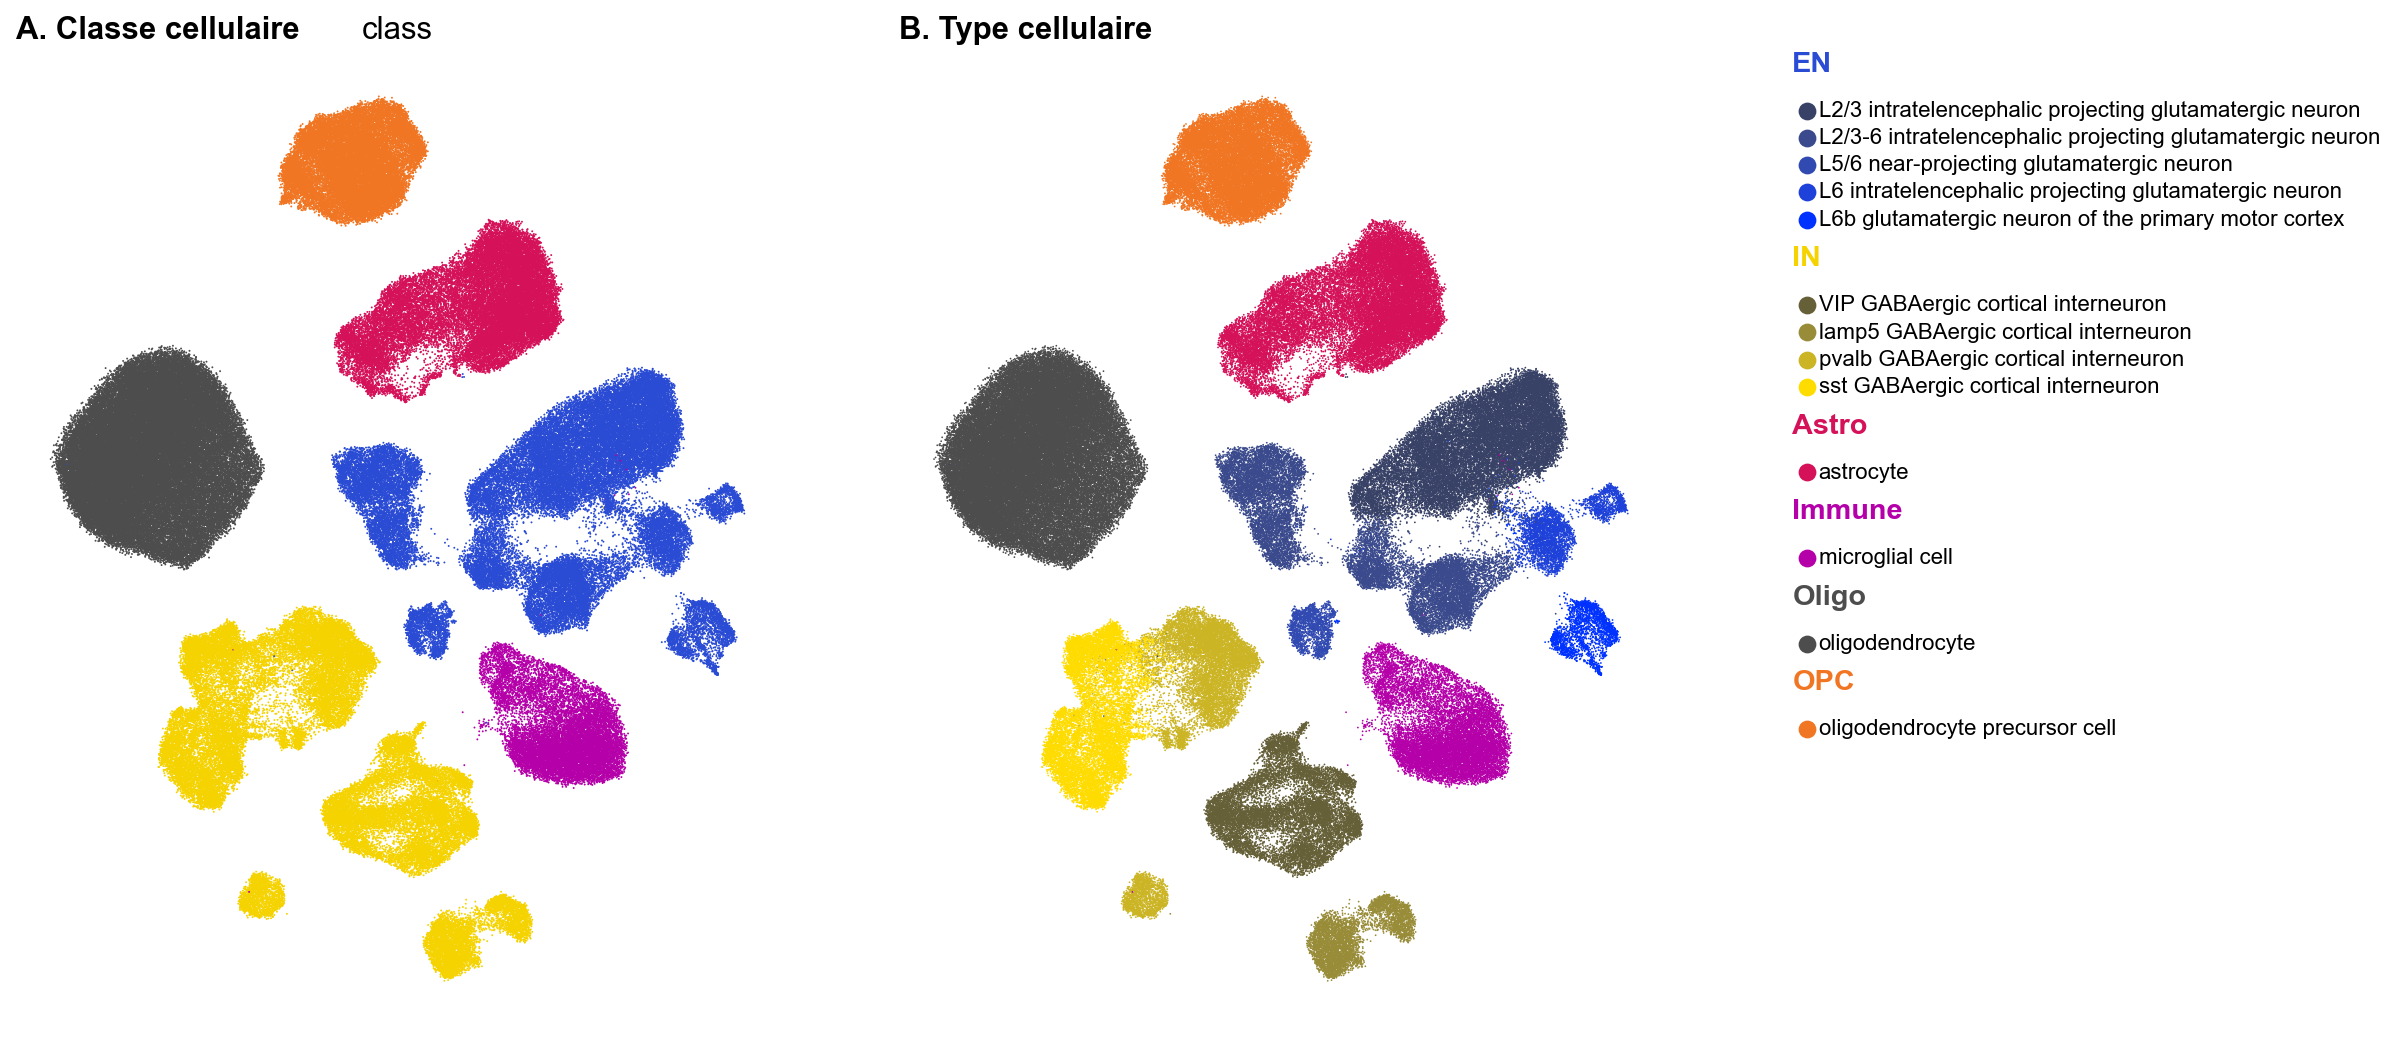

Fig. X — Projection UMAP des principaux types cellulaires du cortex préfrontal (cohorte HBCC, SCZ vs contrôles). Chaque point correspond à un noyau. Les couleurs des types cellulaires sont dérivées de variations contrôlées de luminosité et de saturation autour de la couleur mère de leur classe, permettant une lecture hiérarchique.


In [31]:
adata_ct.obs["class"] = adata_ct.obs["cell_type"].map(celltype_to_class).astype("category")

adata_ct.obs["cell_type_with_class"] = (
    adata_ct.obs["cell_type"].astype(str)
    + " (" + adata_ct.obs["class"].astype(str) + ")"
).astype("category")

class_colors = {
    "Astro":  "#D41159",
    "EN":     "#2A4BD4",
    "IN":     "#F5D300",
    "Oligo":  "#4D4D4D",
    "OPC":    "#F07623",
    "Immune": "#B500A9"
}

adata_ct.uns["class_colors"] = [
    class_colors[c] for c in adata_ct.obs["class"].cat.categories
]

celltype_colors = {}
class_subtypes = {}

for full in adata_ct.obs["cell_type_with_class"].cat.categories:
    cls = full.split("(")[-1].rstrip(")")
    base = class_colors[cls]

    subtypes = [
        x for x in adata_ct.obs["cell_type_with_class"].cat.categories
        if x.endswith(f"({cls})")
    ]

    n = len(subtypes)
    idx = subtypes.index(full)

    hsv = rgb_to_hsv(np.array(to_rgb(base))).copy()
    if n > 1:
        hsv[1] = np.linspace(0.45, 1.0, n)[idx]
        hsv[2] = np.linspace(0.40, 1.0, n)[idx]

    final_hex = rgb2hex(hsv_to_rgb(hsv))
    celltype_colors[full] = final_hex

    class_subtypes.setdefault(cls, []).append({
        "label": full.split(" (")[0],
        "color": final_hex
    })

df = pd.DataFrame({
    "full": list(celltype_colors.keys()),
    "class": [x.split("(")[-1].rstrip(")") for x in celltype_colors.keys()],
    "color": list(celltype_colors.values())
}).sort_values(["class", "full"])

adata_ct.obs["cell_type_with_class"] = pd.Categorical(
    adata_ct.obs["cell_type_with_class"],
    categories=df["full"].tolist(),
    ordered=True
)

adata_ct.uns["cell_type_with_class_colors"] = df["color"].tolist()

fig = plt.figure(figsize=(18, 8))
gs = GridSpec(1, 3, figure=fig, width_ratios=[3.5, 3.5, 2.2], wspace=0.18)

axA = fig.add_subplot(gs[0, 0])
sc.pl.umap(
    adata_ct,
    color="class",
    size=3,
    frameon=False,
    legend_loc=None,
    ax=axA,
    show=False
)
axA.set_title("A. Classe cellulaire", loc="left", fontsize=14, weight="bold")

axB = fig.add_subplot(gs[0, 1])
sc.pl.umap(
    adata_ct,
    color="cell_type_with_class",
    size=2.5,
    frameon=False,
    legend_loc=None,
    title="",
    ax=axB,
    show=False
)
axB.set_title("B. Type cellulaire", loc="left", fontsize=14, weight="bold")

axL = fig.add_subplot(gs[0, 2])
axL.axis("off")

y = 0.98
for cls in class_subtypes:
    axL.text(
        0.02, y, cls, fontsize=13, weight="bold",
        color=class_colors[cls], transform=axL.transAxes
    )
    y -= 0.04

    for st in class_subtypes[cls]:
        axL.plot(
            [0.05], [y], marker="o", markersize=7,
            color=st["color"], transform=axL.transAxes
        )
        axL.text(
            0.075, y, st["label"], fontsize=10,
            va="center", transform=axL.transAxes
        )
        y -= 0.028

    y -= 0.02

plt.show()

print(
    "Fig. X — Projection UMAP des principaux types cellulaires du cortex préfrontal "
    "(cohorte HBCC, SCZ vs contrôles). "
    "Chaque point correspond à un noyau. "
    "Les couleurs des types cellulaires sont dérivées de variations contrôlées de luminosité "
    "et de saturation autour de la couleur mère de leur classe, permettant une lecture hiérarchique."
)


#### **Interprétation de la visualisation UMAP des principaux types cellulaires corticaux**

<small>
La projection UMAP met en évidence une organisation claire des cellules du cortex préfrontal dorsolatéral selon leur identité cellulaire. Le panneau A montre une séparation nette des grandes classes cellulaires (neurones excitateurs, interneurones inhibiteurs, oligodendrocytes, progéniteurs oligodendrocytaires, astrocytes et cellules immunitaires), indiquant que la variance principale capturée par l’UMAP reflète l’identité cellulaire. Le panneau B révèle une structuration cohérente des sous-types au sein de chaque classe, en particulier pour les populations neuronales et gliales, confirmant la pertinence des annotations utilisées. Cette figure valide la qualité du prétraitement et de la réduction de dimension et constitue une référence descriptive pour les analyses différentielles ultérieures, menées de manière stratifiée par type cellulaire dans la comparaison SCZ versus contrôles.
</small>


#### **Finalization of Single-Cell Analysis and Saving of the Analytical Object**

<small>
À l’issue des étapes de normalisation, sélection des gènes hautement variables, réduction de dimension (PCA) et projection UMAP, l’objet AnnData contient l’ensemble des informations nécessaires aux analyses biologiques en aval.  

La structure cellulaire globale est clairement définie, les types cellulaires majeurs sont correctement séparés, et les annotations diagnostiques (SCZ vs contrôles) sont stabilisées. À ce stade, aucune étape supplémentaire d’annotation n’est requise.  

L’objet AnnData est donc sauvegardé tel quel afin de figer l’état analytique du jeu de données. Ce fichier servira directement d’entrée pour les analyses statistiques et les visualisations finales réalisées sous R.
</small>


In [32]:
adata_ct_mem = adata_ct.to_memory()
adata_ct_mem.write(os.path.join(DIRS["DATA"], "HBCC_SCZ_CTRL_postQC_UMAP.h5ad"))

print("✅ Objet analytique final sauvegardé : HBCC_SCZ_CTRL_postQC_UMAP.h5ad")


✅ Objet analytique final sauvegardé : HBCC_SCZ_CTRL_postQC_UMAP.h5ad


#### **Objets H5AD distincts et correctement stratifiés**
<small><br>data/524a8acc-37e5-44fe-aae9-e9a50e07ed24.h5ad (~13.8 Go)
<br>→ HBCC_Cohort RAW Original dataset
<br>→ type : Cell matrix / Gene Expression
<br>→ Data Descriptor : **Lee, D. et al.** Single-cell atlas of transcriptomic vulnerability...

<br>data/HBCC_prefiltered_1500cellsPerDonor_min5cellsPerCellType.h5ad (~3.8 Go)
<br>→ Dictionnaire des métadonnées: data/hbcc_cellxgene_metadata_dictionary.json
<br>→ Sous-échantillon post-EDA

<br>data/HBCC_SCZ_CTRL_postQC.h5ad (~13.4 Go)
<br>→ Objet post-QC complet
<br>→ Archive analytique « source »
<br>→ Trop lourd pour analyses itératives en mémoire

<br>data/HBCC_SCZ_CTRL_postQC_UMAP.h5ad (~6.9 Go)
<br>→ Objet analytique final exploitable
<br>→ QC + simplification diagnostique (CTRL / SCZ)
<br>→ Sélection des types cellulaires majeurs
<br>→ Normalisation, HVG, PCA, voisins, UMAP
<br>→ Visualisation validée et interprétée
</small>


In [34]:
print("\n" + "=" * 80)
print("ANALYTICAL OBJECT SUMMARY")
print("=" * 80)

print(f"Total number of cells: {adata.n_obs:,}")
print(f"Total number of genes: {adata.n_vars:,}")

print("\nDiagnostic group distribution:")
for diag, count in adata.obs["simple_diagnosis"].value_counts().items():
    print(f"  {diag}: {count:,} cells ({count / adata.n_obs * 100:.1f}%)")

print("\nCell type distribution:")
for ct, count in adata.obs["cell_type"].value_counts().items():
    print(f"  {ct}: {count:,} cells ({count / adata.n_obs * 100:.1f}%)")

print("\n✅ Dataset structure validated — ready for differential expression analysis")
print("=" * 80 + "\n")



ANALYTICAL OBJECT SUMMARY
Total number of cells: 414,669
Total number of genes: 34,176

Diagnostic group distribution:
  CTRL: 205,073 cells (49.5%)
  OTHER: 182,395 cells (44.0%)
  SCZ: 27,201 cells (6.6%)

Cell type distribution:
  oligodendrocyte: 102,662 cells (24.8%)
  astrocyte: 49,099 cells (11.8%)
  L2/3 intratelencephalic projecting glutamatergic neuron: 45,914 cells (11.1%)
  oligodendrocyte precursor cell: 35,022 cells (8.4%)
  L2/3-6 intratelencephalic projecting glutamatergic neuron: 33,751 cells (8.1%)
  VIP GABAergic cortical interneuron: 22,245 cells (5.4%)
  sst GABAergic cortical interneuron: 20,794 cells (5.0%)
  microglial cell: 20,282 cells (4.9%)
  pvalb GABAergic cortical interneuron: 20,254 cells (4.9%)
  endothelial cell: 9,914 cells (2.4%)
  GABAergic neuron: 9,476 cells (2.3%)
  lamp5 GABAergic cortical interneuron: 9,302 cells (2.2%)
  L6 intratelencephalic projecting glutamatergic neuron: 8,226 cells (2.0%)
  pericyte: 5,047 cells (1.2%)
  L6 corticothalam

#### **Préparation à l’analyse différentielle (SCZ vs contrôles) : interprétation du résumé descriptif**

<small>
Le résumé descriptif montre que les cellules associées au groupe SCZ représentent une fraction minoritaire de l’ensemble analysé (≈ 6,6 %), tandis qu’une proportion importante correspond à la catégorie <i>OTHER</i>. Ce déséquilibre semble prévisible dans un atlas populationnel, car les proportions reflètent la disponibilité réelle des échantillons et non un design expérimental équilibré. Il ne constitue pas en soi un problème méthodologique, car l’unité d’analyse ici est la cellule (noyau) et non le nombre de donneurs.  

En revanche, pour garantir une comparaison interprétable, l’analyse différentielle sera restreinte aux deux groupes d’intérêt (SCZ et contrôles) : la catégorie <i>OTHER</i> sera exclue avant tout test statistique. De plus, les comparaisons seront réalisées de manière stratifiée par type cellulaire afin d’éviter les effets de composition cellulaire et de s’assurer que les effectifs SCZ restent suffisants au sein de chaque population majeure.  
</small>


#### **Remarque : Annotation manuelle / Clustering**

<small>
Dans cette analyse, aucune étape de clustering (par exemple Leiden) n’a été réalisée, et aucune annotation manuelle basée sur l’identification de nouveaux clusters et de gènes marqueurs n’a été effectuée. Le jeu de données HBCC fournit en effet des annotations cellulaires de référence (`cell_type`), issues d’un atlas single-cell validé, qui ont été directement utilisées tout au long de l’analyse.

La cohérence biologique de ces annotations a été évaluée par inspection de la projection UMAP, laquelle met en évidence une séparation claire des grandes classes cellulaires ainsi qu’une organisation interne cohérente des sous-types. Dans ce cadre, l’UMAP est utilisé exclusivement comme outil de visualisation et de validation qualitative, et non comme base pour définir des groupes cellulaires.

Les analyses ultérieures, en particulier les comparaisons entre groupes diagnostiques (SCZ vs contrôles), sont donc conduites de manière stratifiée par type cellulaire en s’appuyant sur ces annotations de référence.
</small>
